In [18]:
import anndata
import numpy as np
import pandas as pd
import torch
import pyro
import os
import warnings
import logging

from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=UserWarning, message="Found auxiliary vars")
warnings.filterwarnings("ignore", category=UserWarning, message=".*enumerate.*TraceEnum_ELBO.*")

os.environ.pop("SLURM_NTASKS", None)
os.environ.pop("SLURM_NTASKS_PER_NODE", None)
pyro.clear_param_store()

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def get_current_gpu_model():
    """Utility to check the current GPU device, if any."""
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        gpu_name = torch.cuda.get_device_name(device)
        print(f"Current GPU: {gpu_name}")
    else:
        print("CUDA is not available. No GPU detected.")
get_current_gpu_model()

Current GPU: NVIDIA H100 PCIe


In [15]:
import numpy as np
import pandas as pd
import anndata
from anndata import AnnData

def create_perfect_synthetic_anndata(
    n_clones: int = 5,
    n_conditions: int = 2,
    n_cells_per_clone_cond: int = 100,
    n_genes: int = 5,
) -> AnnData:
    total_cells = n_clones * n_conditions * n_cells_per_clone_cond
    X = np.zeros((total_cells, n_genes), dtype=int)
    obs_data = {
        "clone_id": [],
        "true_phenotype": [],
        "covariate": [],
    }
    cell_index = 0
    for clone_i in range(n_clones):
        gene_idx = clone_i % n_genes
        for cond_j in range(n_conditions):
            cov_label = f"condition_{cond_j}"
            for _ in range(n_cells_per_clone_cond):
                X[cell_index, gene_idx] = 100
                obs_data["clone_id"].append(f"clone_{clone_i}")
                obs_data["true_phenotype"].append(f"phen_{clone_i}")
                obs_data["covariate"].append(cov_label)
                cell_index += 1
    obs_df = pd.DataFrame(obs_data)
    var_df = pd.DataFrame(
        index=[f"gene_{g}" for g in range(n_genes)]
    )
    adata = AnnData(
        X=X,
        obs=obs_df,
        var=var_df
    )
    adata.layers["counts"] = adata.X.copy()
    adata.obs["patient"] = "P1"
    return adata
adata = create_perfect_synthetic_anndata(n_clones=10,n_conditions=1,n_cells_per_clone_cond=200, n_genes=10)
adata

/usersoftware/shahs3/users/ceglian/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2000 × 10
    obs: 'clone_id', 'true_phenotype', 'covariate', 'patient'
    layers: 'counts'

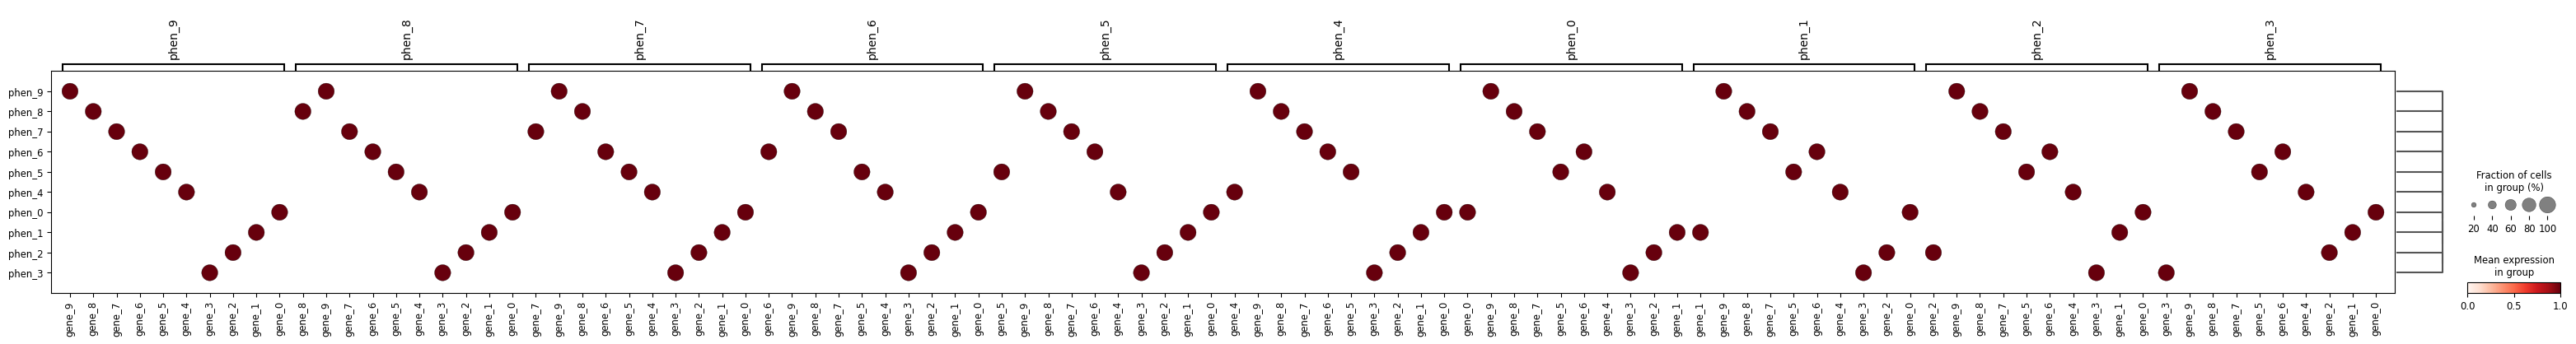

In [16]:
import scanpy as sc
sc.tl.rank_genes_groups(adata,"true_phenotype")
sc.pl.rank_genes_groups_dotplot(adata,standard_scale="var")

/usersoftware/shahs3/users/ceglian/miniforge3/envs/spatial/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


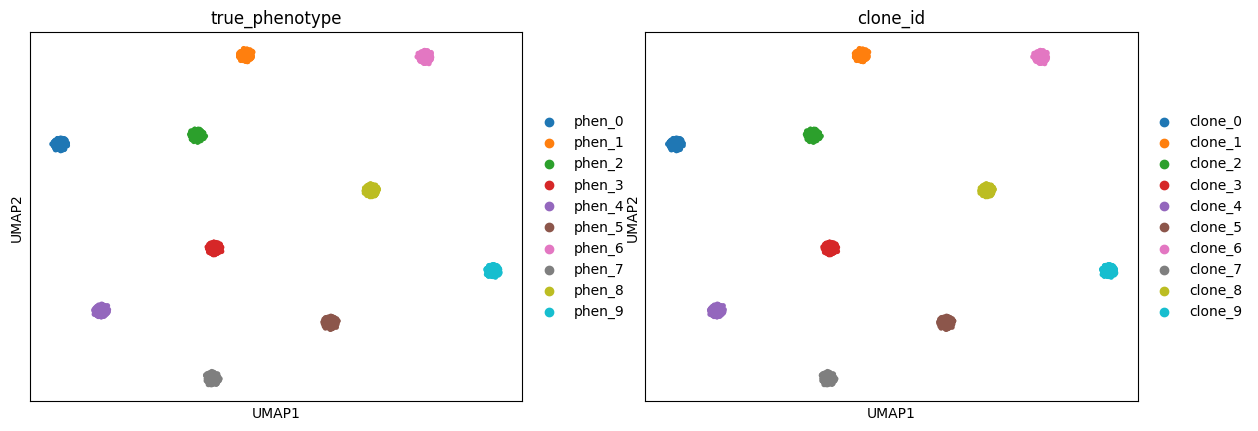

In [17]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["true_phenotype","clone_id"])

In [21]:
import tcri
tcri.ml.TCRIModel.setup_anndata(
    adata,
    layer="counts",
    clonotype_key="clone_id",
    phenotype_key="true_phenotype",
    covariate_key="covariate", #change back to disease states possibly
    batch_key="patient"
)

AnnData object with n_obs × n_vars = 2000 × 10
    obs: 'clone_id', 'true_phenotype', 'covariate', 'patient', 'indices', '_scvi_clonotype_col_in_registry', '_scvi_phenotype_col_in_registry', '_scvi_covariate_col_in_registry', '_scvi_indices', '_scvi_batch'
    uns: 'rank_genes_groups', 'dendrogram_true_phenotype', 'log1p', 'pca', 'neighbors', 'umap', 'true_phenotype_colors', 'clone_id_colors', '_scvi_uuid', '_scvi_manager_uuid', 'tcri_manager'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [25]:
model = tcri.ml.TCRIModel(
    adata,
    n_latent=32,                # Size of the latent space
    n_hidden=64,                # Size of hidden layers in encoder/decoder
    global_scale=1.0,            # Global scaling factor for the clonotype-level prior
    local_scale=0.1,             # Local scaling factor for the ct-level prior
    use_enumeration= False,        # Whether to use enumeration in the model
    n_layers=3,                   # Number of layers in the encoder/decoder networks
    sharp_temperature=1,
    patience=10,
    classifier_hidden=32,
    classifier_dropout=0.,
)

INFO:tcri.model._model:Unified model: c_count=10, ct_count=10, P=10, global_scale=1.0, local_scale=0.1, use_enumeration=False, sharp_temperature=1, sharpness_penalty_scale=0.0.


In [26]:
model.train(
    max_epochs=1000000,            # Total number of training epochs
    batch_size=20000,           # Batch size for training
    margin_scale=0.1,
    margin_value=0.1,
    adaptive_margin=False,
    lr=1e-3,                   # Learning rate for the optimizer
    n_steps_kl_warmup=2000,     # Number of warm-up steps for the KL divergence weight
    clone_alignment_scale=0.1
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/1000000 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 10 records. Best score: 1106.369. Signaling Trainer to stop.


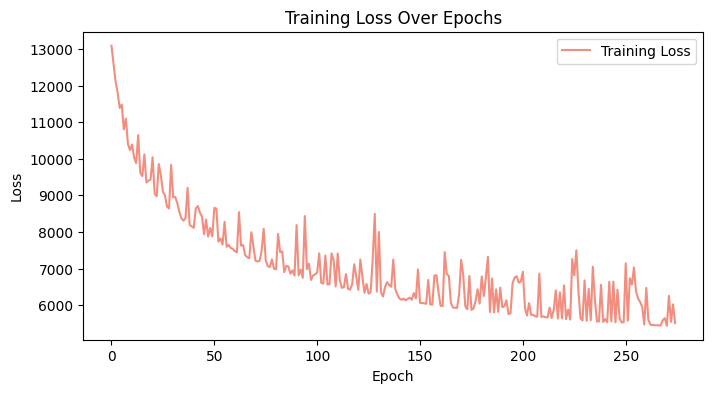

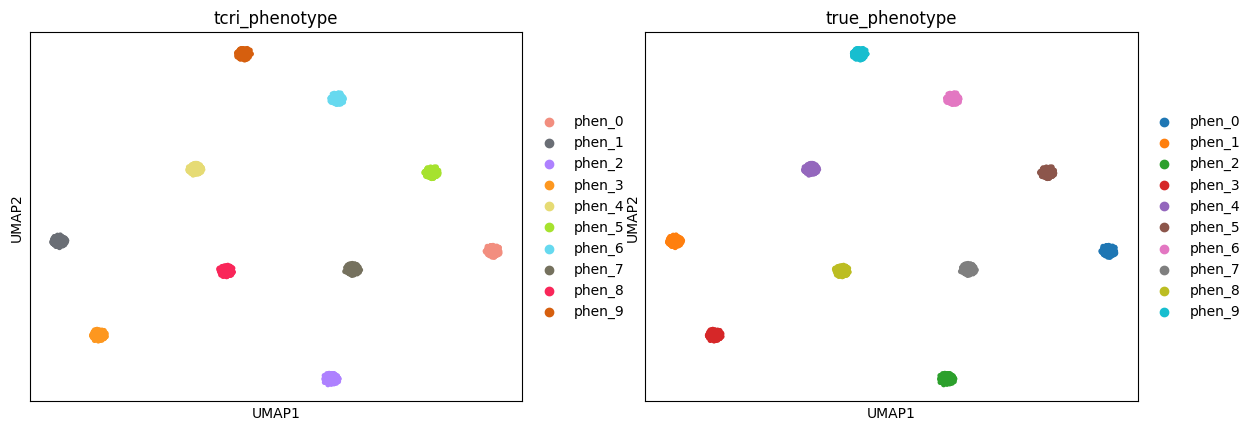

In [28]:
model.plot_loss()
tcri.pp.register_model(adata,model)
tcri.pp.register_phenotype_key(adata,"tcri_phenotype")
tcri.pp.register_clonotype_key(adata,"clone_id")
sc.pp.neighbors(adata,use_rep="X_tcri")
sc.tl.umap(adata)
sc.pl.umap(adata,color=["tcri_phenotype","true_phenotype"])

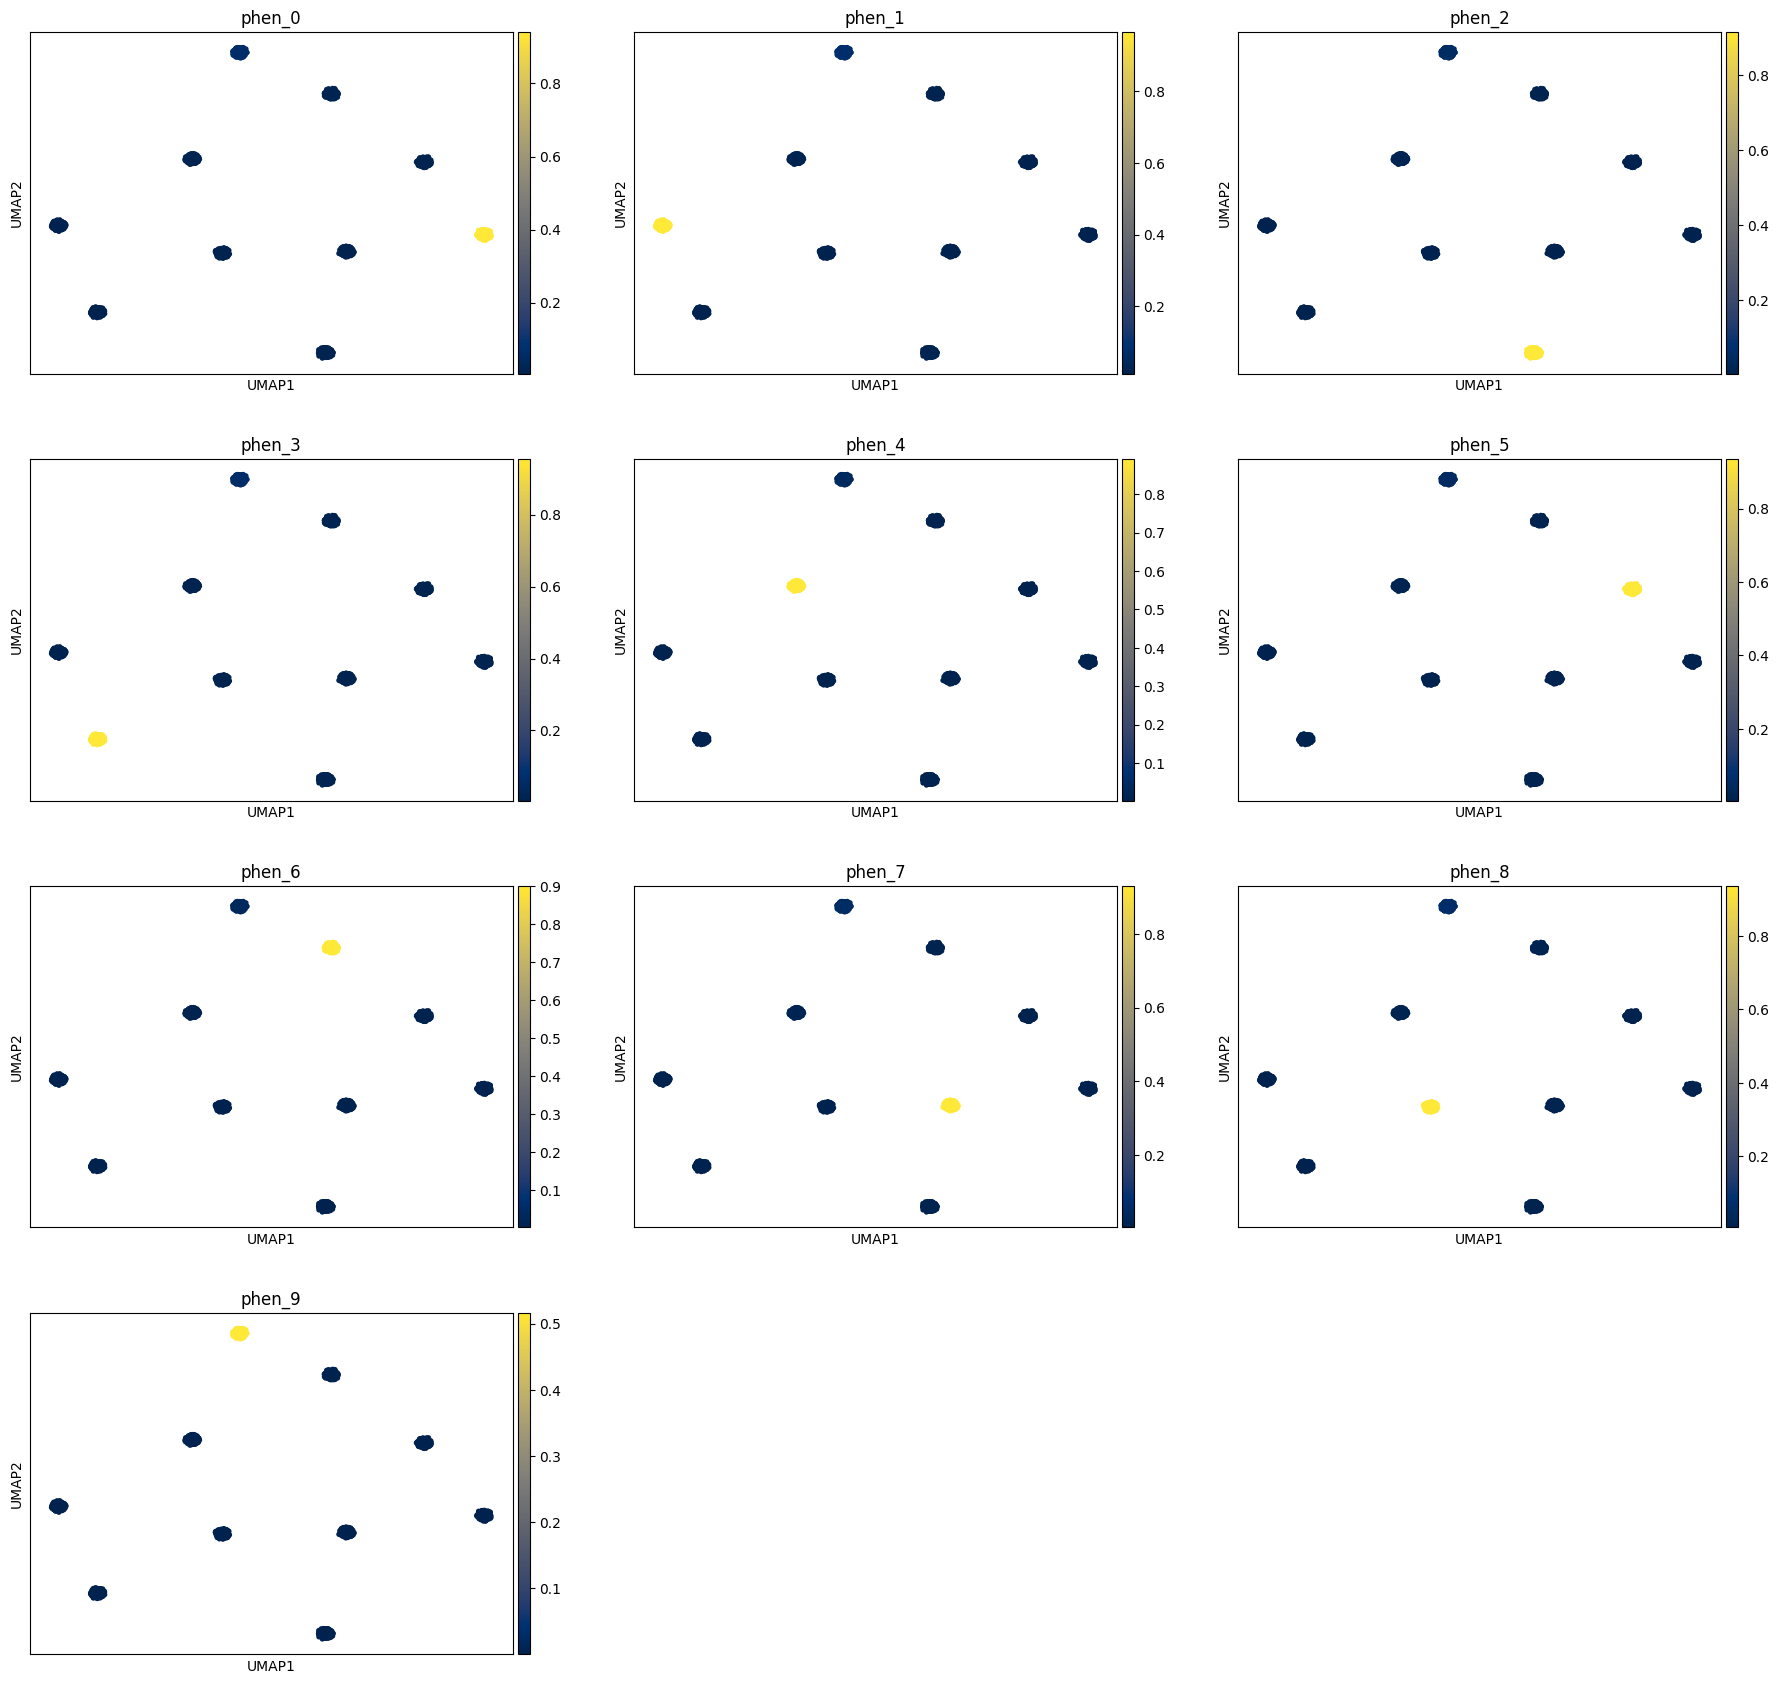

In [30]:
labels = []
for i, x in enumerate(adata.obsm["X_tcri_phenotypes"].T):
    adata.obs["phen_{}".format(i)] = list(x)
    labels.append("phen_{}".format(i))
sc.pl.umap(adata,color=labels,ncols=3,cmap="cividis")

<Axes: xlabel='tcri_phenotype', ylabel='true_phenotype'>

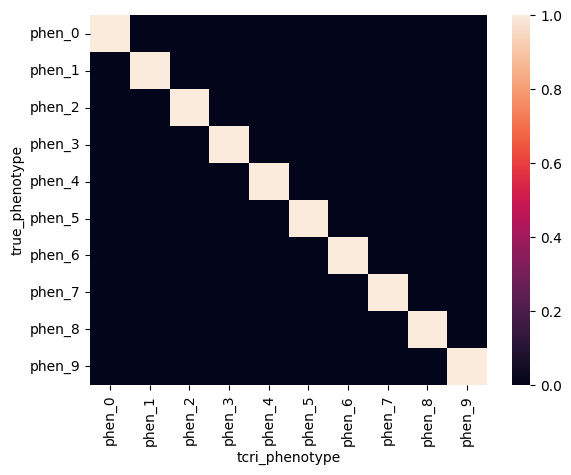

In [32]:
tcri.pl.compare_phenotypes(adata,"true_phenotype","tcri_phenotype")

(10, 10)


array([1.0000001, 0.9999999, 1.       , 1.0000001, 1.0000001, 1.0000001,
       1.0000001, 1.       , 1.0000001, 1.       ], dtype=float32)

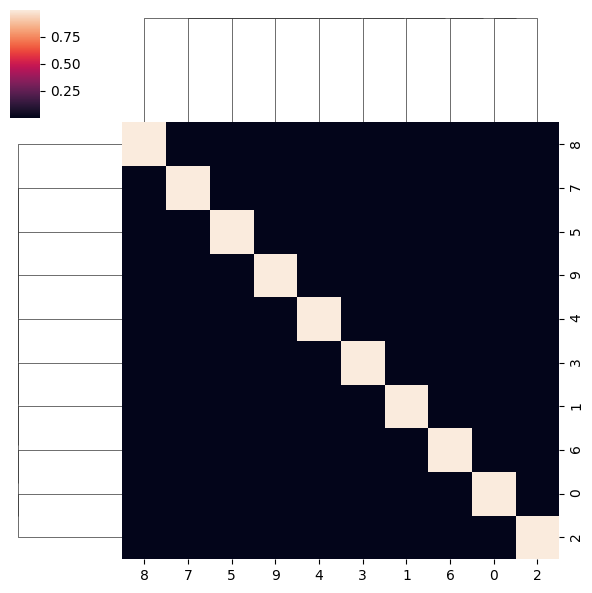

In [36]:
@torch.no_grad()
def get_p_c(self):
    return pyro.param("q_p_c_raw").cpu().numpy()

q_c = get_p_c(model).T 
q_c = q_c / q_c.sum(axis=0)
p_c = q_c.T
sns.clustermap(q_c.T,figsize=(6,6))
q_c.sum(axis=0)

(20, 10)


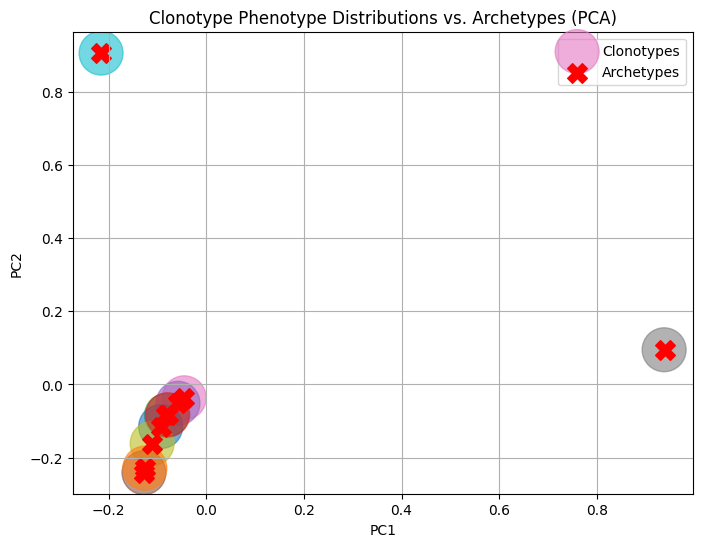

In [41]:
archetypes = model.centers
distances = cdist(p_c, archetypes, metric='euclidean')  # (c_count, K)
nearest_archetype_idx = np.argmin(distances, axis=1)  # closest archetype for each clonotype
archetypes.shape

pca = PCA(n_components=2)
combined = np.vstack([p_c, archetypes])
embedding = pca.fit_transform(combined)
p_c_embed = embedding[:len(p_c)]
archetype_embed = embedding[len(p_c):]

plt.figure(figsize=(8, 6))
plt.scatter(p_c_embed[:, 0], p_c_embed[:, 1], c=nearest_archetype_idx, cmap='tab10', alpha=0.6, s=1000,label='Clonotypes')
plt.scatter(archetype_embed[:, 0], archetype_embed[:, 1], c='red', marker='X', s=200, label='Archetypes')
plt.legend()
plt.title("Clonotype Phenotype Distributions vs. Archetypes (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()